In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

pd.options.display.float_format = '{:.2f}'.format
#pd.set_option('display.max_rows', None)

from model_SARIMA import build_SARIMA, optimal_orders
from model_naiv import build_naive_model
from test_mean import t_test, wilcoxon_test, binomial_test, kolmogorov_test
from test_correlation import residual_plot, acf_resid_plot, box_pierce_test, ljung_box_test, durbin_watson_test, breusch_godfrey_test, run_test
from test_normal import hist_plot
from time_series import seasonal_plot, seasonal_subseries_plot, acf_plot, lag_plot, decompose
from cross_validation import cross_validation, cross_validation_naive


warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

1 Store wählen

In [3]:
# Filtern nach Store
store_number = 3
store = df[df['store'] == store_number].copy()

# Datum als Index setzen
store.set_index('date', inplace=True)

# Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

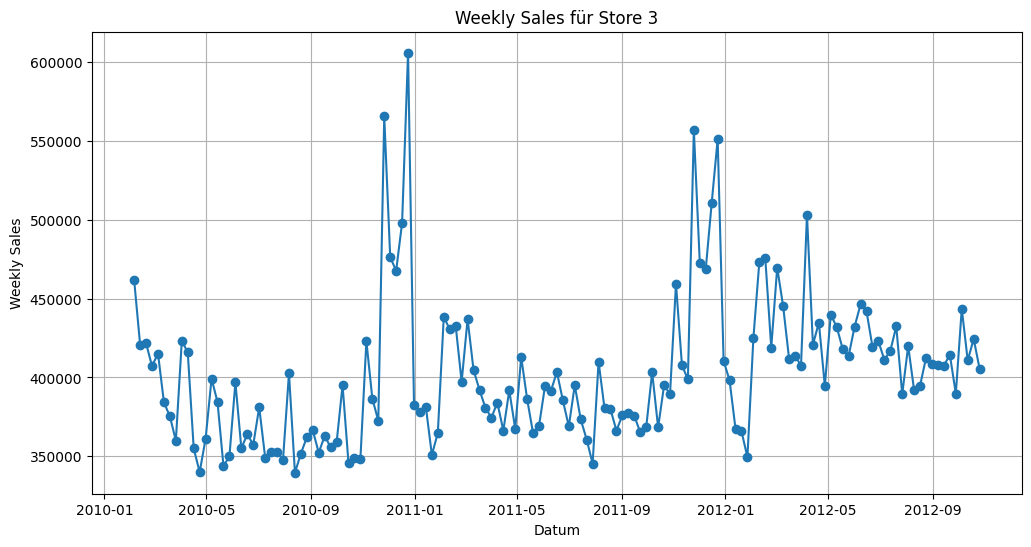

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Weekly Sales für Store {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

Seasonal

In [5]:
#seasonal_plot(sales)
#seasonal_subseries_plot(sales)
#acf_plot(sales)
#lag_plot(sales)
#decompose(sales)

SARIMA Modell

In [6]:
sarima_params  = optimal_orders.get(str(store_number))
order = tuple(sarima_params["order"])
seasonal_order = tuple(sarima_params["seasonal_order"])

sarima_model = build_SARIMA(sales, order = order, seasonal_order = seasonal_order)
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        weekly_sales   No. Observations:                  143
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 52)   Log Likelihood               -1691.974
Date:                             Sun, 16 Mar 2025   AIC                           3393.948
Time:                                     16:07:20   BIC                           3408.727
Sample:                                 02-05-2010   HQIC                          3399.954
                                      - 10-26-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4951      0.116      4.274      0.000       0.268       0.722
ma.L1         -0.8686      0.059    -14.672      0.000      -0.985      -0.753
ar.S.L52       0.3438      0.084      4.089      0.000       0.179       0.509
ar.S.L104      0.1289      0.179      0.719      0.472      -0.222       0.480
sigma2      1.605e+09   1.56e-10   1.03e+19      0.000    1.61e+09    1.61e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.73   Jarque-Bera (JB):               310.16
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.21e+34. Standard errors may be unstable.
"""

Naives Modell

In [7]:
naiv_resid, naiv_fitted = build_naive_model(sales)

Modell wählen

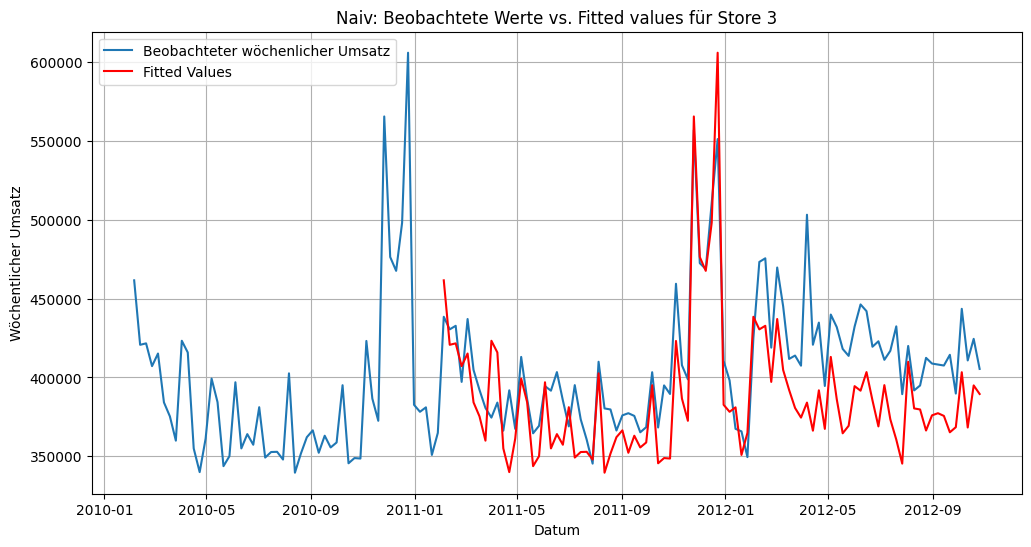

In [8]:
residuen = naiv_resid
fitted_values = naiv_fitted

#residuen = sarima_model.resid
#fitted_values = sarima_model.fittedvalues
#residuen = residuen.iloc[1:]
#fitted_values = fitted_values.iloc[1:]

plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values, color='red', label='Fitted Values')
plt.title('Naiv: Beobachtete Werte vs. Fitted values für Store {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.show()

Korrelation Tests

Box Pierce: 0.6028
Ljung Box: 0.4764
Breusch Godfrey: 1.0000
Run Test: 0.1234
Durbin Watson: 0.4072


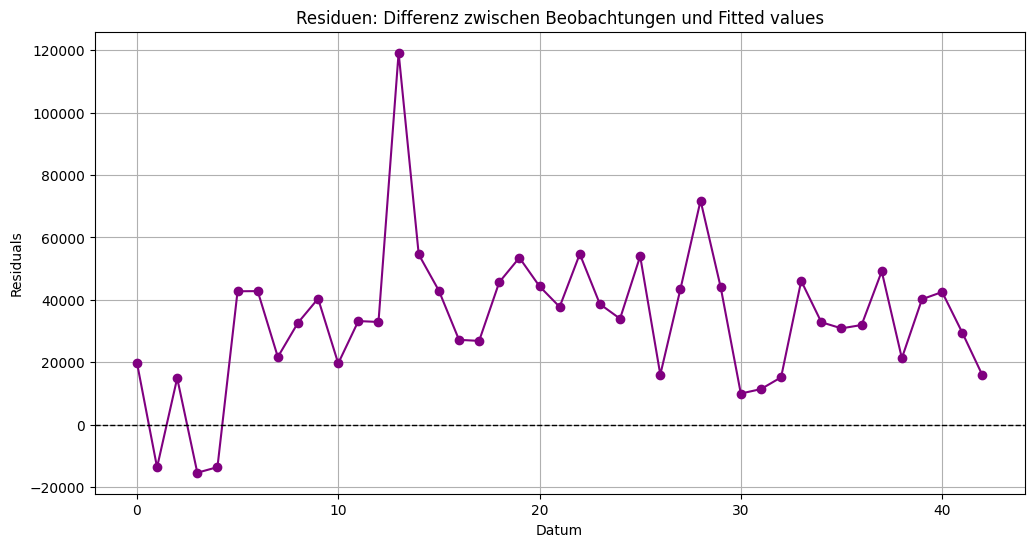

<Figure size 1200x600 with 0 Axes>

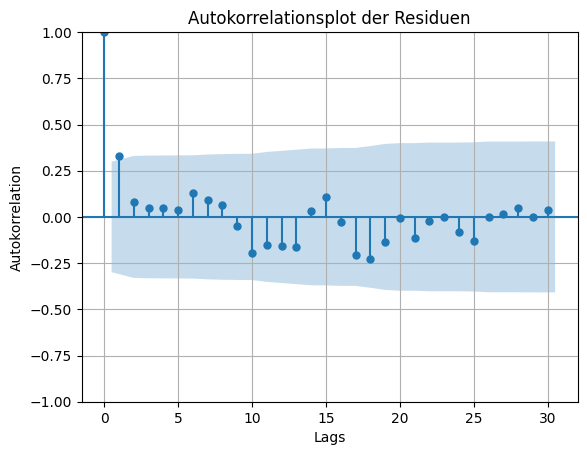

In [15]:
box_pierce_test(residuen)
ljung_box_test(residuen)
breusch_godfrey_test(residuen)
run_test(residuen)

durbin_watson_test(residuen)

residual_plot(residuen)
acf_resid_plot(residuen)


Mittelwert Tests

Mittelwert der Residuen: 33589.3347
T-Test: 0.0000
Wilcoxon Test: 0.0000
Binomial Test: 0.0000
Kolmogorov Test: 0.4199


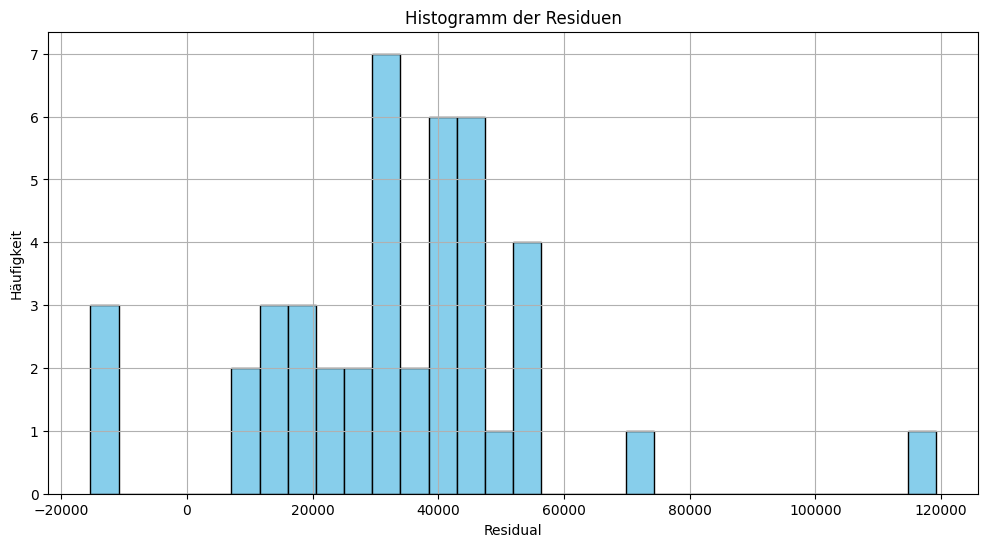

In [14]:
mean_resid = residuen.mean()
print(f"Mittelwert der Residuen: {mean_resid:.4f}")

t_test(residuen)
wilcoxon_test(residuen)
binomial_test(residuen)
kolmogorov_test(residuen)

hist_plot(residuen)


Kreuz Validierung

Seasonal Naive Model Cross-Validation RMSE (period=52): 40438.62182997634


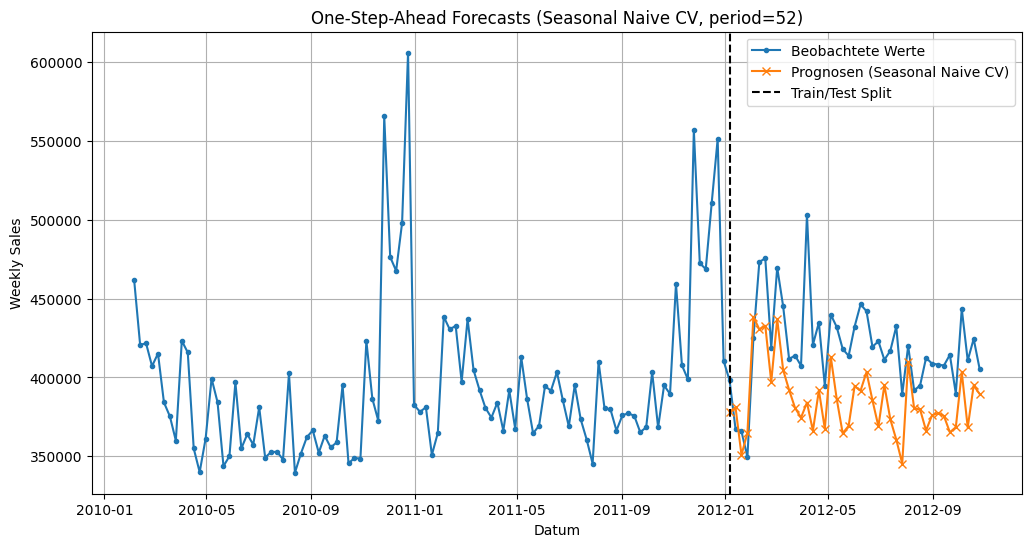

In [11]:
#cv_df, train_size = cross_validation(sales, order = order, seasonal_order = seasonal_order)
cv_df = cross_validation_naive(sales)

# Plot: Beobachtete Werte vs. Prognosen
#plt.figure(figsize=(12, 6))
#plt.plot(sales.index, sales, label='Beobachtete Werte', marker='.', linestyle='-')
#plt.plot(cv_df['date'], cv_df['forecast'], label='Prognosen (CV)', marker='x', linestyle='-')
#plt.axvline(x=sales.index[train_size], color='black', linestyle='--', label='Train/Test Split')
#plt.title('One-Step-Ahead Forecasts (Cross-Validation)')
#plt.xlabel('Datum')
#plt.ylabel('Weekly Sales')
#plt.legend()
#plt.grid(True)
#plt.show()


Korrelations Tests

Box Pierce: 0.6028
Ljung Box: 0.4764
Breusch Godfrey: 1.0000
Run Test: 0.1234
Durbin Watson: 0.4072


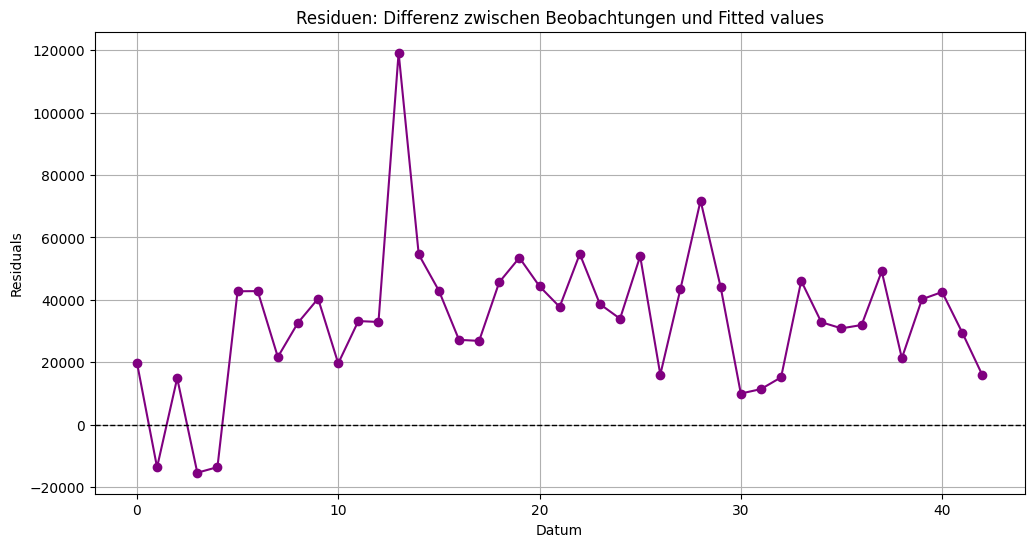

<Figure size 1200x600 with 0 Axes>

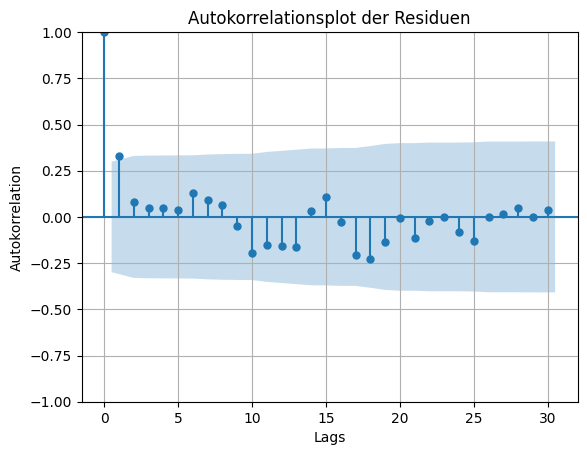

In [ ]:
errors = cv_df['error']

box_pierce_test(errors)
ljung_box_test(errors)
breusch_godfrey_test(errors)
run_test(errors)

durbin_watson_test(errors)

residual_plot(errors)
acf_resid_plot(errors)

Mittelwert Tests

Mittelwert der Errors: 33589.3346511628
T-Test: 0.0000
Wilcoxon Test: 0.0000
Binomial Test: 0.0000
Kolmogorov Test: 0.4199


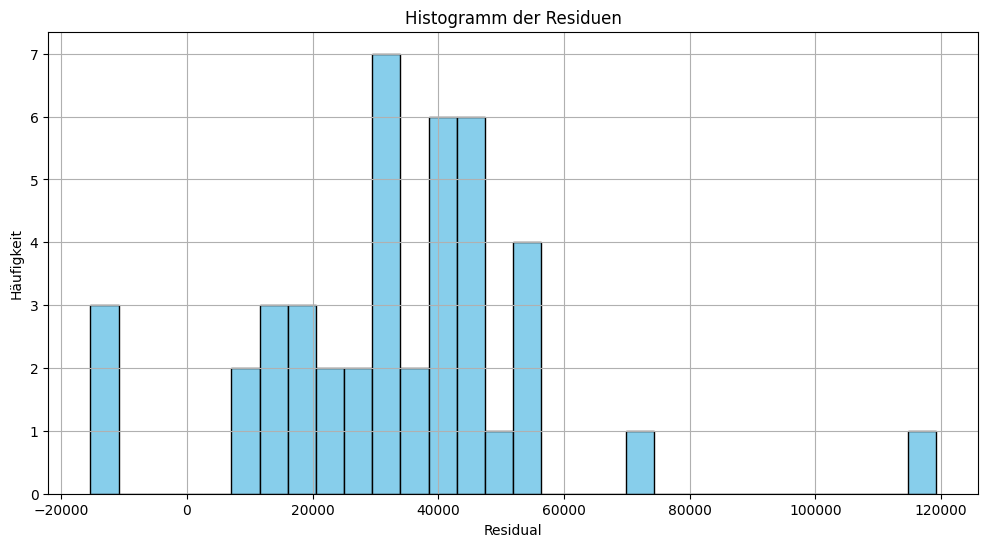

In [ ]:
mean_errors = errors.mean()
print(f'Mittelwert der Errors: {mean_resid}')

t_test(errors)
wilcoxon_test(errors)
binomial_test(errors)
kolmogorov_test(errors)

hist_plot(errors)
